In [150]:
import gym
import gym_foa
from gym import wrappers



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import time
import os

In [151]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

ENV_NAME = 'foa-v0'
env = gym.make(ENV_NAME)
RECORD = False

if RECORD:
    env = wrappers.Monitor(env, 'capa1w', force=True, video_callable=lambda episode_id: True)
TAU = .01
GAMMA = .9
LR_actor = .001
LR_critic = .001
EXPERIENCE_CAPACITY = int(1e4)
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = int(1e4)
MAX_STEP = 100
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]
N_UAVS = 1

[2017-10-09 21:02:43,741] Making new env: foa-v0


In [152]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [153]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:1]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 150)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 150)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fc1 = nn.Linear(150, 100)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(100, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 1)
        self.fc3.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        a = self.fcA(y)
        o = F.relu(s+a)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        o = F.relu(o)
        o = self.fc3(o)
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES/N_UAVS, 150)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(150, 100)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(100, 100)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(100, N_ACTIONS/N_UAVS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [154]:
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    
    
    
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    bat_a0_ = target_actor(bat_o_[:,:N_STATES/N_UAVS])
    #bat_a1_ = target_actor(bat_o_[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2_ = target_actor(bat_o_[:,-N_STATES/N_UAVS:])
    #bat_a_o_ = torch.cat([bat_a0_, bat_a1_, bat_a2_], dim=1)
    bat_a_o_ = bat_a0_

    Gt = bat_r + GAMMA * target_critic(bat_o_, bat_a_o_)
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    bat_a0 = actor(bat_o[:,:N_STATES/N_UAVS])
    #bat_a1 = actor(bat_o[:,N_STATES/N_UAVS:-N_STATES/N_UAVS])
    #bat_a2 = actor(bat_o[:,-N_STATES/N_UAVS:])
    #bat_a_o = torch.cat([bat_a0, bat_a1, bat_a2], dim=1)
    bat_a_o = bat_a0
    
    obj = torch.mean(critic(bat_o, bat_a_o))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()    

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])

In [ ]:


n_vec_r = []
n_vec_avg_cost = []
n_vec_total_cost = []
n_vec_target_update = []
n_vec_experience_refresh = []
for n in xrange(3):    
    start_time = time.time()
    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    vec_r = []
    vec_avg_cost = []
    vec_total_cost = []
    vec_target_update = []
    vec_experience_refresh = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        if epi%(MAX_EPI/50)==0:
            print 'n:{}, epi:{}'.format(n, epi)
            
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        avg_cost = np.zeros([4])
        total_cost = 0
    
        counter = 0
        #for t in xrange(MAX_STEP):    
        while True:
            counter += 1
            
            if RECORD:
                env.render()
            
            a0 = choose_action(o[:N_STATES/N_UAVS], actor)
            #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
            #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
            #a = np.hstack([a0, a1, a2])
            a = a0
            
            o_, r, done, info = env.step(a)
            exp.push(o, a, r, o_)
            
            cost = np.array(info['cost'])
            avg_cost += (cost-avg_cost)/(counter)
            total_cost += r
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            if update_counter % TARGET_UPDATE_FREQUENCY == 0:
                vec_target_update.append(epi)
                update_target(target_actor, target_critic, \
                             actor, critic)
            if update_counter % EXPERIENCE_CAPACITY == 0:
                vec_experience_refresh.append(epi)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break
        
        vec_r.append(acc_r)
        vec_avg_cost.append(avg_cost)
        vec_total_cost.append(total_cost)
        
    n_vec_r.append(vec_r)
    n_vec_avg_cost.append(vec_avg_cost)
    n_vec_total_cost.append(vec_total_cost)
    n_vec_target_update.append(vec_target_update)
    n_vec_experience_refresh.append(vec_experience_refresh)
    
    torch.save(actor.state_dict(), 'actor{}.pt'.format(n))
    
    print("--- %s seconds ---" % (time.time() - start_time))



n:0, epi:0


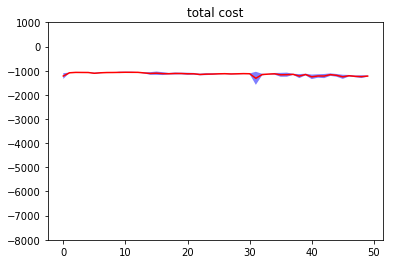

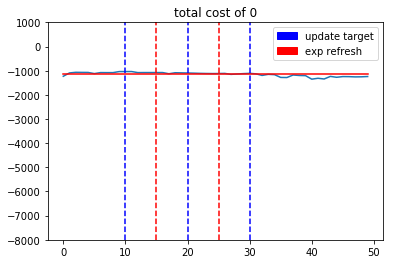

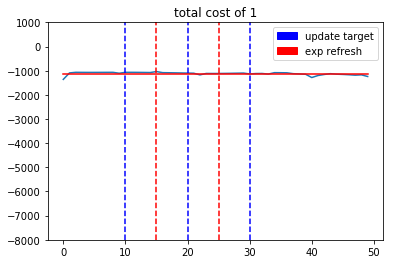

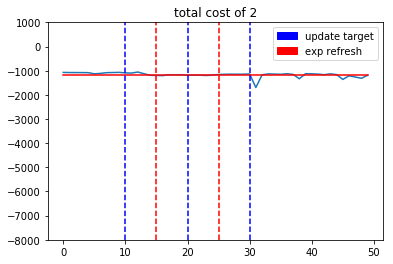

In [149]:
def plot_avg_1d(vec, title=None, xlabel=None, ylabel=None, save=False, ylim=None, begin=0, marker='', target=None, exp=None):
    record = np.array(vec)
    target = np.array(target)
    exp = np.array(exp)
    if len(record.shape) is not 1:
        print 'vec should be 1D array [e0, e1, ...]'
        return
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)
    mu = record.mean(axis=0)
    plt.plot(np.array(range(record.shape[0]))+begin, record, marker)
    plt.plot(np.array(range(record.shape[0]))+begin, mu*np.ones(record.shape[0]), color='red')
    patches = []
    if target is not None and target.shape[0]>0:
        target_color = 'b'
        target_patch = mpatches.Patch(color=target_color, label='update target')
        patches.append(target_patch)
        for t in target:
            plt.axvline(t, ls='dashed', c=target_color)
    if exp is not None and exp.shape[0]>0:
        exp_color = 'r'
        exp_patch = mpatches.Patch(color=exp_color, label='exp refresh')
        patches.append(exp_patch)
        for e in exp:
            plt.axvline(e, ls='dashed', c=exp_color)
    if len(patches)>0:
        plt.legend(handles=patches)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))      
    plt.show()

def plot_avg_2d(vec, title=None, xlabel=None, ylabel=None, save=False, ylim=None, begin=0):
    record = np.array(vec)
    if len(record.shape) is not 2:
        print 'vec should be 2D array [[seq0], [seq1], ...]'
        return
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)
    mu = record.mean(axis=0)
    sigma = record.std(axis=0)
    lower_bound = mu-sigma
    upper_bound = mu+sigma
    plt.plot(np.array(range(mu.shape[0]))+begin, mu, color='red')
    plt.fill_between(np.array(range(mu.shape[0]))+begin, lower_bound, upper_bound, facecolor='blue', alpha=0.5)
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel, rotation=45)
    if save:
        plt.savefig('{}.png'.format(title))
    plt.show()

# data
n_vec_avg_cost = np.array(n_vec_avg_cost)
n_vec_total_cost = np.array(n_vec_total_cost)
n_vec_target_update = np.array(n_vec_target_update)
n_vec_experience_refresh = np.array(n_vec_experience_refresh)


cost = gym_foa.envs.FoaEnv.Cost(*np.rollaxis(n_vec_avg_cost,2))
avg_cost = cost.collision[0]+cost.goal[0]+cost.formation[0]+cost.v_pref[0]

# param
save = False
marker = '.'

target = np.array([10,20,30])
experience = np.array([15,25])

plot_avg_2d(n_vec_total_cost, title='total cost', ylim=[-8000,1000], save=save)
for i in xrange(n_vec_avg_cost.shape[0]):
    plot_avg_1d(n_vec_total_cost[i], title='total cost of {}'.format(i), ylim=[-8000,1000], save=save,\
                target=n_vec_target_update[i], exp=n_vec_experience_refresh[i])



# marker = ''
# int0 = slice(0,500)
# plot_avg_1d(n_vec_total_cost[0][int0], title='total cost: first drop', ylim=[-8000,1000], begin=int0.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int0], title='v_pref: first drop', begin=int0.start, save=save, marker=marker)

# marker = ''
# int1 = slice(3000,3200)
# plot_avg_1d(n_vec_total_cost[0][int1], title='total cost: second drop', ylim=[-8000,1000], begin=int1.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int1], title='v_pref: second drop', begin=int1.start, save=save, marker=marker)

# int2 = slice(7000,8000)
# plot_avg_1d(n_vec_total_cost[0][int2], title='total cost: second drop', ylim=[-8000,1000], begin=int2.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int2], title='v_pref: second drop', begin=int2.start, save=save, marker=marker)

# int3 = slice(9600,10000)
# plot_avg_1d(n_vec_total_cost[0][int3], title='total cost: third drop', ylim=[-8000,1000], begin=int3.start, save=save, marker=marker)
# plot_avg_1d(cost.v_pref[0][int3], title='v_pref: third drop', begin=int3.start, save=save, marker=marker)            
            

In [106]:
torch.save(actor.state_dict(), 'actor_3w.param')
#torch.save(critic.state_dict(), 'critic.param')

#from gym import wrappers

#env = wrappers.Monitor(env, 'exp', force=True)


# actor = Actor()

# actor = torch.load('actor0.pt')
            
# for n in xrange(1):
#     o = env.reset()
#     actor = Actor().cuda()
#     for t in xrange(MAX_STEP):
#         print 'n:{}, t:{}'.format(n, t)
#         env.render()
#         a0 = choose_action(o[:N_STATES/N_UAVS], actor)
#         #a1 = choose_action(o[N_STATES/N_UAVS:-N_STATES/N_UAVS], actor)
#         #a2 = choose_action(o[-N_STATES/N_UAVS:], actor)
#         #a = np.hstack([a0, a1, a2])
        
#         print a0
        
#         o_, r, done, info = env.step(a0)
    
#         o = o_
#         if done:
#             break

In [95]:
import pickle

# Saving the objects:
with open('capa_1w.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump(n_vec_total_cost, f)

## Getting back the objects:
#with open('objs.pickle') as f:  # Python 3: open(..., 'rb')
#    k = pickle.load(f)
    
#print cost

In [71]:
x = np.array(range(10)).reshape(2,-1)
s = slice(None,2)
print s.step

None
